In [50]:
#imports 
import os
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import DataLoader,Dataset

import spacy
import statistics
import torchtext
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image
import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.metrics import Accuracy

In [51]:
torch.backends.cudnn.benchmark = True
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
BATCH_SIZE = 128
NUM_WORKERS = 8
SPLIT_VAL = 0.2

EMBED_SIZE = 256
HIDDEN_SIZE = 256
NUM_LAYERS = 1

LRATE = 3e-5
MAX_EPOCHS = 100
NUM_GPU=1

In [64]:
class Vocabulary(object):
    def __init__(self, freq_threshold, spacy_eng=None):
        self.start_word = "<SOS>"
        self.end_word = "<EOS>"
        self.pad_word = "<PAD>"
        self.unk_word = "<UNK>"
        
        self.itos = {0: self.pad_word, 1: self.start_word, 2: self.end_word, 3: self.unk_word}
        self.stoi = {self.pad_word: 0, self.start_word: 1, self.end_word: 2, self.unk_word: 3}
        
        self.itos = {0: self.start_word, 1: self.end_word, 2: self.pad_word, 3: self.unk_word}
        self.stoi = {self.start_word: 0, self.end_word: 1, self.pad_word: 2, self.unk_word: 3}
        
        
        self.freq_threshold = freq_threshold
        if spacy_eng==None:
            self.spacy_eng = spacy.load('en_core_web_sm')
        else:
            self.spacy_eng = spacy_eng
        
    def __len__(self):
        return len(self.itos)

    def tokenizer_eng(self, text):
        tokenizer = [tok.text.lower() for tok in self.spacy_eng.tokenizer(text)]
        return tokenizer
        
    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]


class FlickrDataset(Dataset):
    def __init__(self, root_dir, caption_file, caption_delimiter='|', 
                 image_column='image_name', text_column='caption_text',
                 transform=None, freq_threshold=5,
                 train=True, split_val=0.2):
        self.root_dir = root_dir
        self.caption_file = caption_file
        self.caption_delimiter = caption_delimiter
        self.image_column = image_column
        self.text_column = text_column
        
        self.dataframe = pd.read_csv(caption_file, delimiter=caption_delimiter)
        self.transform = transform
        
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.dataframe[self.text_column].tolist())
        
        self.train = train 
        self.split_val = split_val
        self._do_split_train_valid()
        
    def _do_split_train_valid(self):
        imgs_train, imgs_valid, caps_train, caps_valid = train_test_split(
            self.dataframe[self.image_column], self.dataframe[self.text_column], 
            test_size=self.split_val, random_state=16
        )
        
        if self.train:
            self.imgs = imgs_train
            self.captions = caps_train
        else:
            self.imgs = imgs_valid
            self.captions = caps_valid
            
        self.imgs = self.imgs.tolist()
        self.captions = self.captions.tolist()
        

    def __len__(self):
        return len(self.imgs)
    
    def _numericalized_caption(self, caption):
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        
        return numericalized_caption

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        ncaption = self._numericalized_caption(caption)

        return img, torch.tensor(ncaption)


class CaptionCollate:
    def __init__(self, pad_idx, batch_first=True):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self, batch):
        batch.sort(key=lambda x: len(x[1]), reverse=True)
        (images, captions) = zip(*batch)
        
        imgs = [img.unsqueeze(0) for img in images]
        imgs = torch.cat(imgs, dim=0)
        
        lengths = [len(cap) for cap in captions]
        targets = torch.zeros(len(captions), max(lengths)).long()
        for idx, cap in enumerate(captions):
            end = lengths[idx]
            targets[idx, :end] = cap[:end]
        return imgs, targets, lengths
    

def flickr8k_dataloader(root_folder, caption_file, transform, train=True,
                        batch_size=32, num_workers=8, shuffle=True, pin_memory=True):
    
    dataset = FlickrDataset(root_folder, caption_file, transform=transform, train=train)
    PAD_IDX = dataset.vocab.stoi["<PAD>"]
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=num_workers,
                            shuffle=shuffle, pin_memory=pin_memory, 
                            collate_fn=CaptionCollate(pad_idx=PAD_IDX))
    
    return dataloader, dataset

In [72]:
train_transform = transforms.Compose([
    transforms.Resize((356, 356)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
])

valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
])

root_dir = "data/flickr30k/images/"
caption_file = "data/flickr30k/captions.txt"

train_loader, trainset = flickr8k_dataloader(root_dir, caption_file, transform=train_transform,  
                                             num_workers=NUM_WORKERS, shuffle=True, train=True)

valid_loader, validset = flickr8k_dataloader(root_dir, caption_file, transform=valid_transform, 
                                             num_workers=NUM_WORKERS, shuffle=False, train=False)

In [73]:
img, cap = trainset[200]
print([trainset.vocab.itos[token] for token in cap.tolist()])
len(trainset), len(validset)

['<SOS>', 'crowd', 'of', 'people', 'wearing', 'blue', 'standing', 'on', 'the', 'street', 'by', 'buildings', '.', '<EOS>']


(127132, 31783)

In [74]:
imgs, caps, lengths = next(iter(valid_loader))

targets = pack_padded_sequence(caps, lengths, batch_first=True)
targets[0][0]

print([trainset.vocab.itos[token] for token in targets[0].tolist()])
print(imgs[0].shape)

['<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', '<SOS>', 'many', 'a', 'a', 'at', 'a', 'two', 'a', 'a', 'a', 'a', 'a', 'a', 'two', 'a', 'a', 'a', 'woman', 'a', 'a', 'a', 'woman', 'older', 'brown', 'the', 'a', 'a', 'a', 'a', 'a', 'a', 'two', 'various', 'member', 'woman', 'group', 'a', 'balding', 'women', 'person', 'young', 'little', 'man', 'boy', 'young', 'men', 'group', 'man', 'player', 'looking', 'red', 'group', 'woman', 'on', 'women', 'dog', 'upper', 'surfer', 'lady', 'man', 'man', 'young', 'woman', 'children', 'marathon', 'of', 'in', 'of', 'beach', 'man', 'dressed', 'painting', 'man', 'girl', 'playing', 'uses', 'bespectacled', 'climb', 'of', 'wearing', 'for', 'through', '-', 'of', 'in', 'stage', 'in', 'leaps', 'deck', 'in', 'is', 'smiling', 'is', 'girl', '

In [75]:
class Encoder(nn.Module):
    def __init__(self, embed_size, train_cnn=False, resnet_model=models.resnet50):
        super(Encoder, self).__init__()
        self.train_cnn = train_cnn
        resnet = resnet_model(pretrained=True)
        resnet = self._fine_tune(resnet)
        modules = list(resnet.children())[:-1]
        
        self.resnet = nn.Sequential(*modules)
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def _fine_tune(self, resnet):
        if self.train_cnn:
            for param in resnet.parameters():
                param.requires_grad_(True)
        else:
            for param in resnet.parameters():
                param.requires_grad_(False)
                
        return resnet
    
    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        embed = self.bn(self.embed(features))
        return embed


class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(Decoder, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        
        self._init_weights()
                
    def _init_weights(self):
        torch.nn.init.xavier_uniform_(self.linear.weight)
        torch.nn.init.xavier_uniform_(self.embed.weight)

    def forward(self, features, captions, lengths):
        features = features.unsqueeze(dim=1)
        
        embeddings = self.embed(captions)
        embeddings = torch.cat((features, embeddings), dim=1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    

class ImageCaptionNet(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(ImageCaptionNet, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        
        self.encoder = Encoder(embed_size)
        self.decoder = Decoder(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions, lengths):
        features = self.encoder(images)
        outputs = self.decoder(features, captions, lengths)
        return outputs

In [76]:
class ImageCaptionTask(pl.LightningModule):
    def __init__(self, model, optimizers, criterion, vocab_size, scheduler=None, batch_first=True):
        super().__init__()
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.scheduler = scheduler
        self.vocab_size = vocab_size
        self.batch_first = batch_first
        self.metric = Accuracy()
        
    def forward(self, imgs, captions):
        outputs = self.model(imgs, captions[:-1])
        return outputs
        
    def shared_step(self, batch, batch_idx):
        imgs, captions, lengths = batch
        packed = pack_padded_sequence(captions, lengths, batch_first=self.batch_first)
        targets, _, _, _ = packed
        
        outputs = self.model(imgs, captions, lengths)
        loss = criterion(outputs, targets)
        acc = self.metric(outputs, targets)
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self.shared_step(batch, batch_idx)
        result = pl.TrainResult(loss)
        result.log_dict({'trn_loss': loss, 'trn_acc': acc})
        
        return result
    
    def validation_step(self, batch, batch_idx):
        loss, acc = self.shared_step(batch, batch_idx)
        result = pl.EvalResult(checkpoint_on=loss)
        result.log_dict({'val_loss': loss, 'val_acc': acc})
        
        return result
    
    def configure_optimizers(self):
        if self.scheduler:
            return [self.optimizer], [self.scheduler]
        return self.optimizer
    
  

In [77]:
# initialize model, loss etc
PAD_INDEX = trainset.vocab.stoi["<PAD>"]
VOCAB_SIZE = len(trainset.vocab)
print(f'VOCAB_SIZE : {VOCAB_SIZE}')

model = ImageCaptionNet(EMBED_SIZE, HIDDEN_SIZE, VOCAB_SIZE, NUM_LAYERS)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_INDEX)
optimizer = optim.Adam(model.parameters(), lr=LRATE)
task = ImageCaptionTask(model, optimizer, criterion, vocab_size=VOCAB_SIZE)

VOCAB_SIZE : 7666


In [78]:
checkpoint_path = '../saved_model'
# DEFAULTS used by the Trainer
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_top_k=1,
    verbose=True,
    monitor='checkpoint_on',
    mode='min',
    prefix='flickr30k_net_'
)

tensorboard_logger = pl_loggers.TensorBoardLogger('../logs/flickr30k')

/opt/anaconda3/envs/dlearn/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Checkpoint directory ../saved_model exists and is not empty with save_top_k != 0.All files in this directory will be deleted when a checkpoint is saved!
  warnings.warn(*args, **kwargs)


In [79]:
trainer = pl.Trainer(max_epochs=MAX_EPOCHS, gpus=NUM_GPU, logger=tensorboard_logger, checkpoint_callback=checkpoint_callback)
trainer.fit(task, train_loader, valid_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
/opt/anaconda3/envs/dlearn/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ImageCaptionNet  | 28 M  
1 | criterion | CrossEntropyLoss | 0     
2 | metric    | Accuracy         | 0     



Epoch 00000: val_checkpoint_on reached 4.85262 (best 4.85262), saving model to ../saved_model/flickr30k_net_epoch=0.ckpt as top 1



Epoch 00001: val_checkpoint_on reached 4.15102 (best 4.15102), saving model to ../saved_model/flickr30k_net_epoch=1.ckpt as top 1



Epoch 00002: val_checkpoint_on reached 3.87422 (best 3.87422), saving model to ../saved_model/flickr30k_net_epoch=2.ckpt as top 1



Epoch 00003: val_checkpoint_on reached 3.72246 (best 3.72246), saving model to ../saved_model/flickr30k_net_epoch=3.ckpt as top 1



Epoch 00004: val_checkpoint_on reached 3.60441 (best 3.60441), saving model to ../saved_model/flickr30k_net_epoch=4.ckpt as top 1



Epoch 00005: val_checkpoint_on reached 3.50914 (best 3.50914), saving model to ../saved_model/flickr30k_net_epoch=5.ckpt as top 1



Epoch 00006: val_checkpoint_on reached 3.43504 (best 3.43504), saving model to ../saved_model/flickr30k_net_epoch=6.ckpt as top 1



Epoch 00007: val_checkpoint_on reached 3.36879 (best 3.36879), saving model to ../saved_model/flickr30k_net_epoch=7.ckpt as top 1



Epoch 00008: val_checkpoint_on reached 3.31488 (best 3.31488), saving model to ../saved_model/flickr30k_net_epoch=8.ckpt as top 1



Epoch 00009: val_checkpoint_on reached 3.27040 (best 3.27040), saving model to ../saved_model/flickr30k_net_epoch=9.ckpt as top 1



Epoch 00010: val_checkpoint_on reached 3.22731 (best 3.22731), saving model to ../saved_model/flickr30k_net_epoch=10.ckpt as top 1



Epoch 00011: val_checkpoint_on reached 3.18935 (best 3.18935), saving model to ../saved_model/flickr30k_net_epoch=11.ckpt as top 1



Epoch 00012: val_checkpoint_on reached 3.15794 (best 3.15794), saving model to ../saved_model/flickr30k_net_epoch=12.ckpt as top 1



Epoch 00013: val_checkpoint_on reached 3.12802 (best 3.12802), saving model to ../saved_model/flickr30k_net_epoch=13.ckpt as top 1



Epoch 00014: val_checkpoint_on reached 3.09681 (best 3.09681), saving model to ../saved_model/flickr30k_net_epoch=14.ckpt as top 1



Epoch 00015: val_checkpoint_on reached 3.07303 (best 3.07303), saving model to ../saved_model/flickr30k_net_epoch=15.ckpt as top 1



Epoch 00016: val_checkpoint_on reached 3.04794 (best 3.04794), saving model to ../saved_model/flickr30k_net_epoch=16.ckpt as top 1



Epoch 00017: val_checkpoint_on reached 3.02661 (best 3.02661), saving model to ../saved_model/flickr30k_net_epoch=17.ckpt as top 1



Epoch 00018: val_checkpoint_on reached 3.00497 (best 3.00497), saving model to ../saved_model/flickr30k_net_epoch=18.ckpt as top 1



Epoch 00019: val_checkpoint_on reached 2.98784 (best 2.98784), saving model to ../saved_model/flickr30k_net_epoch=19.ckpt as top 1



Epoch 00020: val_checkpoint_on reached 2.96950 (best 2.96950), saving model to ../saved_model/flickr30k_net_epoch=20.ckpt as top 1



Epoch 00021: val_checkpoint_on reached 2.95460 (best 2.95460), saving model to ../saved_model/flickr30k_net_epoch=21.ckpt as top 1



Epoch 00022: val_checkpoint_on reached 2.94212 (best 2.94212), saving model to ../saved_model/flickr30k_net_epoch=22.ckpt as top 1



Epoch 00023: val_checkpoint_on reached 2.92669 (best 2.92669), saving model to ../saved_model/flickr30k_net_epoch=23.ckpt as top 1



Epoch 00024: val_checkpoint_on reached 2.91433 (best 2.91433), saving model to ../saved_model/flickr30k_net_epoch=24.ckpt as top 1



Epoch 00025: val_checkpoint_on reached 2.89917 (best 2.89917), saving model to ../saved_model/flickr30k_net_epoch=25.ckpt as top 1



Epoch 00026: val_checkpoint_on reached 2.88760 (best 2.88760), saving model to ../saved_model/flickr30k_net_epoch=26.ckpt as top 1



Epoch 00027: val_checkpoint_on reached 2.87324 (best 2.87324), saving model to ../saved_model/flickr30k_net_epoch=27.ckpt as top 1



Epoch 00028: val_checkpoint_on reached 2.86365 (best 2.86365), saving model to ../saved_model/flickr30k_net_epoch=28.ckpt as top 1



Epoch 00029: val_checkpoint_on reached 2.85537 (best 2.85537), saving model to ../saved_model/flickr30k_net_epoch=29.ckpt as top 1



Epoch 00030: val_checkpoint_on reached 2.84772 (best 2.84772), saving model to ../saved_model/flickr30k_net_epoch=30.ckpt as top 1



Epoch 00031: val_checkpoint_on reached 2.83481 (best 2.83481), saving model to ../saved_model/flickr30k_net_epoch=31.ckpt as top 1



Epoch 00032: val_checkpoint_on reached 2.82565 (best 2.82565), saving model to ../saved_model/flickr30k_net_epoch=32.ckpt as top 1



Epoch 00033: val_checkpoint_on reached 2.81889 (best 2.81889), saving model to ../saved_model/flickr30k_net_epoch=33.ckpt as top 1



Epoch 00034: val_checkpoint_on reached 2.81056 (best 2.81056), saving model to ../saved_model/flickr30k_net_epoch=34.ckpt as top 1



Epoch 00035: val_checkpoint_on reached 2.80240 (best 2.80240), saving model to ../saved_model/flickr30k_net_epoch=35.ckpt as top 1



Epoch 00036: val_checkpoint_on reached 2.79307 (best 2.79307), saving model to ../saved_model/flickr30k_net_epoch=36.ckpt as top 1



Epoch 00037: val_checkpoint_on reached 2.78849 (best 2.78849), saving model to ../saved_model/flickr30k_net_epoch=37.ckpt as top 1



Epoch 00038: val_checkpoint_on reached 2.77894 (best 2.77894), saving model to ../saved_model/flickr30k_net_epoch=38.ckpt as top 1



Epoch 00039: val_checkpoint_on reached 2.77667 (best 2.77667), saving model to ../saved_model/flickr30k_net_epoch=39.ckpt as top 1



Epoch 00040: val_checkpoint_on reached 2.76818 (best 2.76818), saving model to ../saved_model/flickr30k_net_epoch=40.ckpt as top 1



Epoch 00041: val_checkpoint_on reached 2.76234 (best 2.76234), saving model to ../saved_model/flickr30k_net_epoch=41.ckpt as top 1



Epoch 00042: val_checkpoint_on reached 2.75670 (best 2.75670), saving model to ../saved_model/flickr30k_net_epoch=42.ckpt as top 1



Epoch 00043: val_checkpoint_on reached 2.74845 (best 2.74845), saving model to ../saved_model/flickr30k_net_epoch=43.ckpt as top 1



Epoch 00044: val_checkpoint_on reached 2.74537 (best 2.74537), saving model to ../saved_model/flickr30k_net_epoch=44.ckpt as top 1



Epoch 00045: val_checkpoint_on reached 2.73486 (best 2.73486), saving model to ../saved_model/flickr30k_net_epoch=45.ckpt as top 1



Epoch 00046: val_checkpoint_on reached 2.73346 (best 2.73346), saving model to ../saved_model/flickr30k_net_epoch=46.ckpt as top 1



Epoch 00047: val_checkpoint_on reached 2.72845 (best 2.72845), saving model to ../saved_model/flickr30k_net_epoch=47.ckpt as top 1



Epoch 00048: val_checkpoint_on reached 2.72358 (best 2.72358), saving model to ../saved_model/flickr30k_net_epoch=48.ckpt as top 1



Epoch 00049: val_checkpoint_on reached 2.71688 (best 2.71688), saving model to ../saved_model/flickr30k_net_epoch=49.ckpt as top 1



Epoch 00050: val_checkpoint_on reached 2.71406 (best 2.71406), saving model to ../saved_model/flickr30k_net_epoch=50.ckpt as top 1



Epoch 00051: val_checkpoint_on reached 2.71049 (best 2.71049), saving model to ../saved_model/flickr30k_net_epoch=51.ckpt as top 1



Epoch 00052: val_checkpoint_on reached 2.70533 (best 2.70533), saving model to ../saved_model/flickr30k_net_epoch=52.ckpt as top 1



Epoch 00053: val_checkpoint_on reached 2.69935 (best 2.69935), saving model to ../saved_model/flickr30k_net_epoch=53.ckpt as top 1



Epoch 00054: val_checkpoint_on reached 2.69614 (best 2.69614), saving model to ../saved_model/flickr30k_net_epoch=54.ckpt as top 1



Epoch 00055: val_checkpoint_on reached 2.69126 (best 2.69126), saving model to ../saved_model/flickr30k_net_epoch=55.ckpt as top 1



Epoch 00056: val_checkpoint_on  was not in top 1



Epoch 00057: val_checkpoint_on reached 2.68646 (best 2.68646), saving model to ../saved_model/flickr30k_net_epoch=57.ckpt as top 1



Epoch 00058: val_checkpoint_on reached 2.68200 (best 2.68200), saving model to ../saved_model/flickr30k_net_epoch=58.ckpt as top 1



Epoch 00059: val_checkpoint_on reached 2.67546 (best 2.67546), saving model to ../saved_model/flickr30k_net_epoch=59.ckpt as top 1



Epoch 00060: val_checkpoint_on reached 2.67506 (best 2.67506), saving model to ../saved_model/flickr30k_net_epoch=60.ckpt as top 1



Epoch 00061: val_checkpoint_on reached 2.67203 (best 2.67203), saving model to ../saved_model/flickr30k_net_epoch=61.ckpt as top 1



Epoch 00062: val_checkpoint_on reached 2.66657 (best 2.66657), saving model to ../saved_model/flickr30k_net_epoch=62.ckpt as top 1



Epoch 00063: val_checkpoint_on  was not in top 1



Epoch 00064: val_checkpoint_on reached 2.66293 (best 2.66293), saving model to ../saved_model/flickr30k_net_epoch=64.ckpt as top 1



Epoch 00065: val_checkpoint_on reached 2.66096 (best 2.66096), saving model to ../saved_model/flickr30k_net_epoch=65.ckpt as top 1



Epoch 00066: val_checkpoint_on reached 2.65526 (best 2.65526), saving model to ../saved_model/flickr30k_net_epoch=66.ckpt as top 1



Epoch 00067: val_checkpoint_on reached 2.65452 (best 2.65452), saving model to ../saved_model/flickr30k_net_epoch=67.ckpt as top 1



Epoch 00068: val_checkpoint_on reached 2.65356 (best 2.65356), saving model to ../saved_model/flickr30k_net_epoch=68.ckpt as top 1



Epoch 00069: val_checkpoint_on reached 2.64873 (best 2.64873), saving model to ../saved_model/flickr30k_net_epoch=69.ckpt as top 1



Epoch 00070: val_checkpoint_on reached 2.64495 (best 2.64495), saving model to ../saved_model/flickr30k_net_epoch=70.ckpt as top 1



Epoch 00071: val_checkpoint_on reached 2.64417 (best 2.64417), saving model to ../saved_model/flickr30k_net_epoch=71.ckpt as top 1



Epoch 00072: val_checkpoint_on reached 2.64252 (best 2.64252), saving model to ../saved_model/flickr30k_net_epoch=72.ckpt as top 1



Epoch 00073: val_checkpoint_on  was not in top 1



Epoch 00074: val_checkpoint_on reached 2.63559 (best 2.63559), saving model to ../saved_model/flickr30k_net_epoch=74.ckpt as top 1


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 00076: val_checkpoint_on  was not in top 1



Epoch 00077: val_checkpoint_on reached 2.63031 (best 2.63031), saving model to ../saved_model/flickr30k_net_epoch=77.ckpt as top 1



Epoch 00078: val_checkpoint_on reached 2.62618 (best 2.62618), saving model to ../saved_model/flickr30k_net_epoch=78.ckpt as top 1



Epoch 00079: val_checkpoint_on reached 2.62205 (best 2.62205), saving model to ../saved_model/flickr30k_net_epoch=79.ckpt as top 1



Epoch 00080: val_checkpoint_on reached 2.61993 (best 2.61993), saving model to ../saved_model/flickr30k_net_epoch=80.ckpt as top 1



Epoch 00081: val_checkpoint_on  was not in top 1

Epoch 00082: val_checkpoint_on  was not in top 1
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Epoch 00083: val_checkpoint_on reached 2.61627 (best 2.61627), saving model to ../saved_model/flickr30k_net_epoch=83.ckpt as top 1



Epoch 00084: val_checkpoint_on reached 2.61543 (best 2.61543), saving model to ../saved_model/flickr30k_net_epoch=84.ckpt as top 1



Epoch 00085: val_checkpoint_on reached 2.61346 (best 2.61346), saving model to ../saved_model/flickr30k_net_epoch=85.ckpt as top 1



Epoch 00086: val_checkpoint_on reached 2.60937 (best 2.60937), saving model to ../saved_model/flickr30k_net_epoch=86.ckpt as top 1



Epoch 00087: val_checkpoint_on  was not in top 1



Epoch 00088: val_checkpoint_on reached 2.60805 (best 2.60805), saving model to ../saved_model/flickr30k_net_epoch=88.ckpt as top 1



Epoch 00089: val_checkpoint_on reached 2.60741 (best 2.60741), saving model to ../saved_model/flickr30k_net_epoch=89.ckpt as top 1



Epoch 00090: val_checkpoint_on reached 2.60708 (best 2.60708), saving model to ../saved_model/flickr30k_net_epoch=90.ckpt as top 1



Epoch 00091: val_checkpoint_on reached 2.60200 (best 2.60200), saving model to ../saved_model/flickr30k_net_epoch=91.ckpt as top 1



Epoch 00092: val_checkpoint_on  was not in top 1



Epoch 00093: val_checkpoint_on reached 2.60037 (best 2.60037), saving model to ../saved_model/flickr30k_net_epoch=93.ckpt as top 1



Epoch 00094: val_checkpoint_on  was not in top 1



Epoch 00095: val_checkpoint_on reached 2.59996 (best 2.59996), saving model to ../saved_model/flickr30k_net_epoch=95.ckpt as top 1



Epoch 00096: val_checkpoint_on reached 2.59513 (best 2.59513), saving model to ../saved_model/flickr30k_net_epoch=96.ckpt as top 1



Epoch 00097: val_checkpoint_on  was not in top 1



Epoch 00098: val_checkpoint_on reached 2.59331 (best 2.59331), saving model to ../saved_model/flickr30k_net_epoch=98.ckpt as top 1



Epoch 00099: val_checkpoint_on reached 2.59164 (best 2.59164), saving model to ../saved_model/flickr30k_net_epoch=99.ckpt as top 1
Saving latest checkpoint..


1

In [49]:
saved_checkpoint_path = '../saved_model/flickr8k_net_epoch=99.ckpt'
checkpoint = torch.load(saved_checkpoint_path, map_location=lambda storage, loc: storage)
task.load_state_dict(checkpoint['state_dict'])
# model.load_state_dict(task.model.state_dict())
# task.load_from_checkpoint(saved_checkpoint_path, optimizers=optimizer, criterion=criterion, vocab_size=VOCAB_SIZE)

<All keys matched successfully>

In [80]:
class ImageCaptionTest(object):
    def __init__(self, model, vocab, max_len=20):
        self.model = model
        self.vocab = vocab
        self.max_len = max_len
        
        self.model.eval()
        self.encoder = model.encoder
        self.decoder = model.decoder
        
    def process_sentence_list(self, sentences):
        sentence_list = []
        for sentence in sentences:
            sentence_list.append(self.clean_sentence(sentence))
        return sentence_list
    
    def clean_sentence(self, sentence_index):
        sentence = ""
        for i in sentence_index:
            word = self.vocab.itos[i]
            if (word == self.vocab.start_word):
                continue
            elif (word == self.vocab.end_word):
                break
            else:
                sentence = sentence + " " + word
        return sentence
    
    def sample(self, images, states=None):
        with torch.no_grad():
            inputs = self.encoder(images).unsqueeze(dim=1)
            sampled_ids = []
            for i in range(self.max_len):
                hiddens, states = self.decoder.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
                outputs = self.decoder.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
                _, predicted = outputs.max(1)                        # predicted: (batch_size)
                sampled_ids.append(predicted)
                inputs = self.decoder.embed(predicted)                       # inputs: (batch_size, embed_size)
                inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
            sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
            return sampled_ids.tolist()
    
    def generate_caption(self, images):
        sentences_indexs = self.sample(images)
        sentences = self.process_sentence_list(sentences_indexs)
        return sentences
    
def clean_sentence(sentence_index, vocab):
    sentence = ""
    for i in sentence_index:
        word = vocab.itos[i]
        if (word == vocab.start_word):
            continue
        elif (word == vocab.end_word):
            break
        else:
            sentence = sentence + " " + word
    return sentence

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted    :  a man in a blue shirt is sitting on a chair in a room with a red and white
ground truth :  a man in a green cap is repairing a broken chair .
tensor([   0,    6,   10,    4,    6,   73,  178,   16,  975,    6, 2220,  261,
           5,    1])


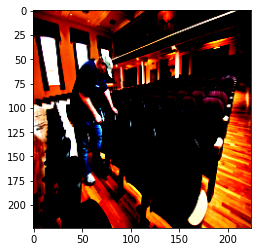

In [86]:
img, txt = validset[40]
img = img.unsqueeze(0)

image_caption = ImageCaptionTest(model, validset.vocab)
result = image_caption.generate_caption(img)


print(f'predicted    : {result[0]}')
print(f'ground truth : {clean_sentence(txt.tolist(), validset.vocab)}')
plt.imshow(img.squeeze().permute(1,2,0), cmap='gray')
print(txt)